In [1]:
import torch
import torch.nn as nn
from torch import optim 
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 

from tqdm import tqdm
import matplotlib.pyplot as plt

from model import VAE
from data import Ego4d, DEVICE, BATCH_SIZE, transform1, transform2, ResumableRandomSampler, StaticSampler, MarioDataset

device cuda is ready


In [2]:
model = VAE(32, batch_size=32).to(DEVICE)
model.load_state_dict(torch.load('MARIO.pt', weights_only=True))

<All keys matched successfully>

In [3]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), 

In [15]:
print('transform initializate sucsess')
train_dataset = MarioDataset(root_dir='/home/qwest/data_for_ml/MARIO_FOR_RNN/win1/',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
sampler = StaticSampler(train_dataset)
#sampler.set_state(checkpoint['sampler_state'])
print("train_sampler init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=32,
                           #shuffle=False,
                           sampler=sampler,)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_sampler init
train_loader init


In [16]:
len(train_loader)

135

In [17]:
x = next(iter(train_loader))

In [18]:
x[0].shape

torch.Size([3, 64, 64])

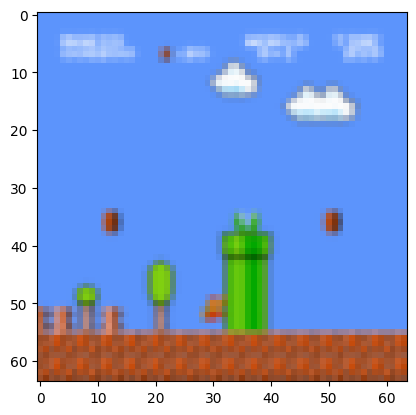

In [19]:
plt.imshow(x[2].cpu().numpy().transpose(1,2,0))

In [10]:
outputs = []

In [20]:
for i in range(len(train_loader)):
    x = next(iter(train_loader))
    Z = model.encode(x.to(DEVICE))
    outputs.append(Z[0])

In [21]:
outputs[0].shape

torch.Size([32, 32, 4, 4])

In [22]:
result = torch.stack(outputs) 

In [23]:
result.shape

torch.Size([273, 32, 32, 4, 4])

In [13]:
x.shape

torch.Size([32, 3, 64, 64])

In [39]:
Z = model.encode(x.to(DEVICE))

In [40]:
Z[0].size()

torch.Size([32, 32, 4, 5])

In [24]:
import numpy as np

In [25]:
np.save('Z', result.detach().cpu().numpy())

In [34]:
Z = Z[0].view(1131, -1, Z[0].size(1)).to(DEVICE)

In [37]:
Z.size()

torch.Size([1131, 16, 32])

IntSlider(value=0, continuous_update=False, description='Update array:', layout=Layout(width='500px'), max=50)

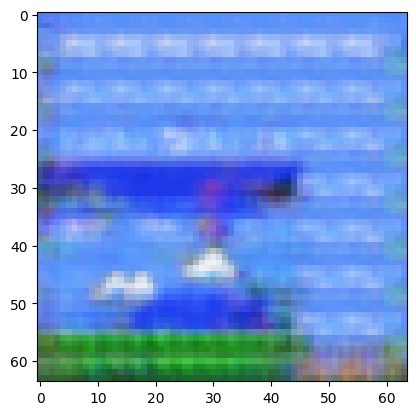

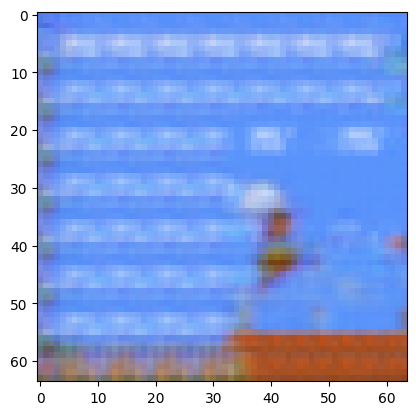

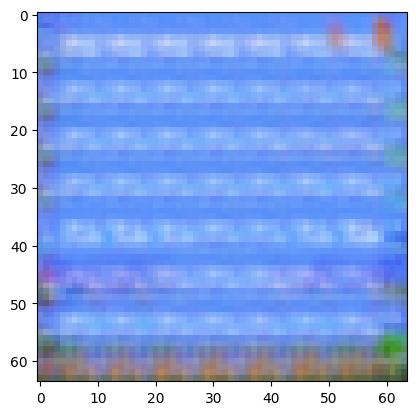

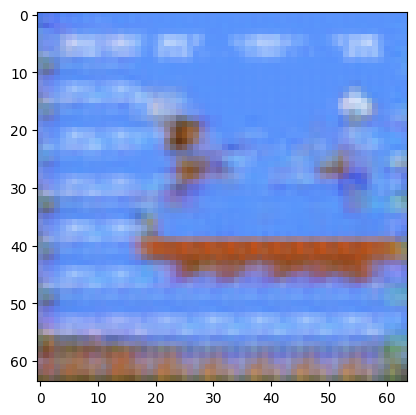

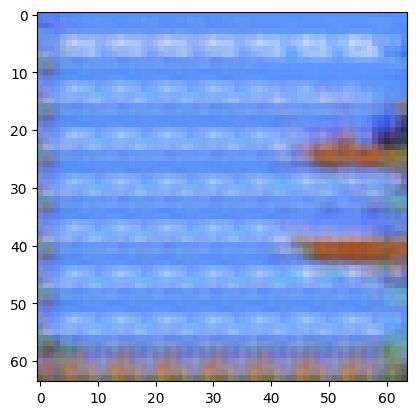

In [15]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Создаем исходный массив


# Функция для изменения случайных элементов
def update_array(change):
  array = np.zeros((1, 32, 4, 4)) # Важно указать global, чтобы функция могла изменить глобальную переменную
  indices = np.random.choice(np.arange(array.size), size=8, replace=False)
  new_values = np.random.uniform(-5.0, 5.0, size=8)
  array.reshape(-1)[indices] = new_values
  samples = model.decoder(torch.tensor(array).float().to(DEVICE)).detach().cpu().numpy().transpose(0, 2, 3, 1)
  plt.imshow(samples[0])
  #print("Modified array:\n", array)


# Создаем ползунок32
  min=0,
  max=50, # Максимальное значение - для демонстрации, можно изменить
  step=1,
  description='Update array:',
  continuous_update=False, # Обновление только при отпускании ползунка
  orientation='horizontal',
  layout=widgets.Layout(width='500px')
)

# Связываем ползунок с функцией обновления
slider.observe(update_array, names='value')


# Выводим ползунок и начальный массив
display(slider)
#print("Initial array:\n", array)

IntSlider(value=8, continuous_update=False, description='total changes:', max=512, min=1)

FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='di:', max=5.0, min=-5.0, step=0.001)

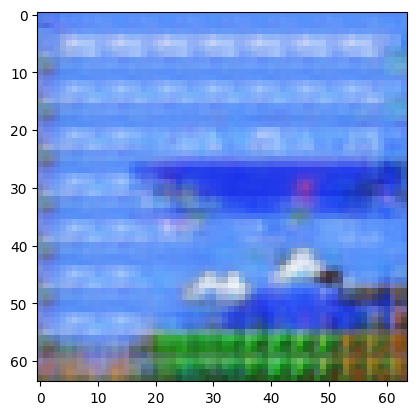

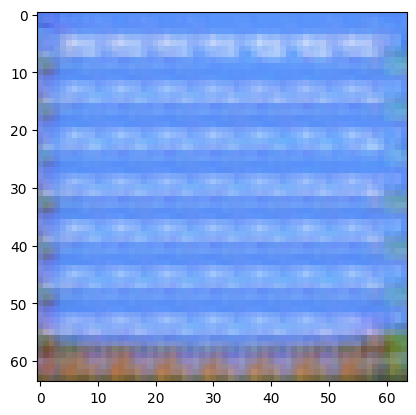

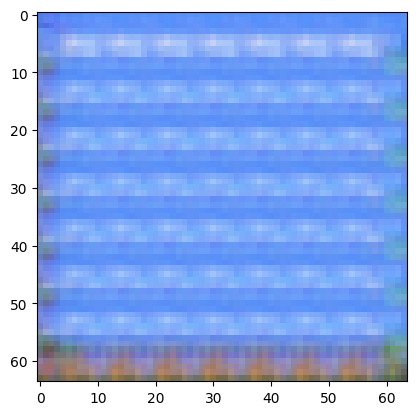

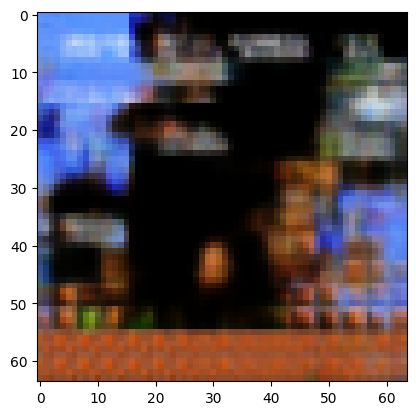

In [17]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def update_array(change):
  array_64x4x4 = np.zeros((1, 32, 4, 4))
  num_changes = slider_num_changes.value
  min_val = slider_range.value[0]
  max_val = slider_range.value[1]

  indices = np.random.choice(np.arange(array_64x4x4.size), size=num_changes, replace=False)
  linear_indices = np.unravel_index(indices, array_64x4x4.shape)
  
  new_values = np.random.uniform(min_val, max_val, size=num_changes)

  array_64x4x4[linear_indices] = new_values

  samples = model.decoder(torch.tensor(array_64x4x4).float().to(DEVICE)).detach().cpu().numpy().transpose(0, 2, 3, 1)
  plt.imshow(samples[0])


slider_num_changes = widgets.IntSlider(
  min=1,
  max=32 * 4 * 4,
  step=1,
  value=8,
  description='total changes:',
  continuous_update=False
)
slider_num_changes.observe(update_array, names='value')

slider_range = widgets.FloatRangeSlider(
  value=[-1.0, 1.0],
  min=-5.0,
  max=5.0,
  step=0.001,
  description='di:',
  continuous_update=False
)
slider_range.observe(update_array, names='value')


display(slider_num_changes)
display(slider_range)


In [1]:
import matplotlib.pyplot as plt

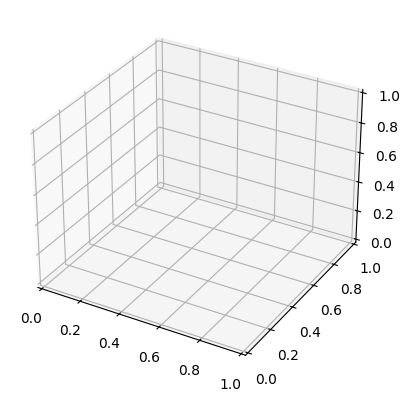

In [3]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
plt.show()

In [7]:
import numpy

In [8]:
X, Y = numpy.meshgrid([1,2,3], [4,5,6,7])

In [9]:
def makeData ():
    # Строим сетку в интервале от -10 до 10, имеющую 100 отсчетов по обеим координатам
    x = numpy.linspace (-10, 10, 100)
    y = numpy.linspace (-10, 10, 100)

    # Создаем двумерную матрицу-сетку
    xgrid, ygrid = numpy.meshgrid(x, y)

    # В узлах рассчитываем значение функции
    z = numpy.sin (xgrid) * numpy.sin (ygrid) / (xgrid * ygrid)
    return xgrid, ygrid, z

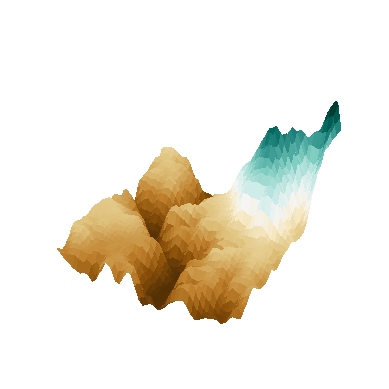

In [68]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cbook, cm
from matplotlib.colors import LightSource

# Load and format data
dem = cbook.get_sample_data('jacksboro_fault_dem.npz')
z = dem['elevation']
nrows, ncols = z.shape
x = np.linspace(dem['xmin'], dem['xmax'], ncols)
y = np.linspace(dem['ymin'], dem['ymax'], nrows)
x, y = np.meshgrid(x, y)

region = np.s_[1:48, 1:48]
x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.set_axis_off()

ls = LightSource(380, 90)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
#surf = ax.plot_surface(x, y, z, 70, cmap='BrBG') #BrBG #twilight_shifted

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,
                   linewidth=0, antialiased=False, shade=False, cmap='BrBG')
#plt.savefig("myimg.svg")
plt.show()



(10,) (31,) (7,)
(21,) (2,) (8,)
(45,) (32,) (6,)
(2,) (28,) (10,)
(9,) (32,) (1,)
(40,) (16,) (10,)
(8,) (39,) (3,)
(34,) (26,) (10,)
(17,) (26,) (2,)
(10,) (39,) (1,)
(42,) (3,) (6,)
(11,) (2,) (7,)
(35,) (4,) (3,)
(47,) (6,) (9,)
(10,) (27,) (8,)
(7,) (48,) (2,)
(17,) (2,) (9,)
(2,) (29,) (6,)
(2,) (50,) (8,)
(16,) (2,) (7,)
(23,) (40,) (7,)
(28,) (35,) (7,)
(19,) (46,) (10,)
(38,) (40,) (7,)
(27,) (43,) (4,)
(20,) (28,) (4,)
(28,) (20,) (3,)
(49,) (45,) (8,)
(20,) (33,) (6,)
(40,) (15,) (10,)
(43,) (9,) (9,)
(42,) (20,) (6,)
(48,) (23,) (10,)
(17,) (7,) (4,)
(32,) (39,) (4,)
(40,) (8,) (6,)
(46,) (13,) (2,)
(15,) (42,) (3,)
(16,) (50,) (5,)
(5,) (29,) (8,)
(17,) (48,) (1,)
(33,) (21,) (2,)
(2,) (29,) (3,)
(45,) (42,) (5,)
(32,) (50,) (7,)
(27,) (49,) (4,)
(40,) (49,) (1,)
(36,) (12,) (9,)
(42,) (40,) (1,)
(36,) (22,) (5,)
(46,) (29,) (9,)
(32,) (39,) (3,)
(29,) (37,) (9,)
(32,) (4,) (8,)
(17,) (26,) (10,)
(39,) (19,) (8,)
(15,) (38,) (5,)
(19,) (25,) (4,)
(42,) (40,) (4,)
(21,) (48

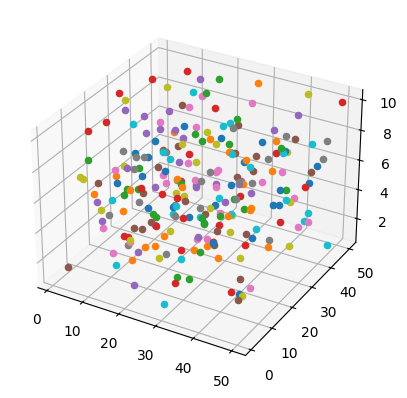

In [33]:
import random
import itertools
import matplotlib.pyplot as plt 
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D 
import time

def ramdom_position(total_number, blue_number):
    my_list = list(range(1, total_number))
    random.shuffle(my_list)
    results = my_list
    index = 1
    nn = 1

    fig1 = plt.figure()
    ax = fig1.add_subplot(projection='3d')

    random_list = list(itertools.product(range(1, 51), range(1, 51), range(1,11)))
    for colour in results:
        if colour < blue_number:
            a = (index, 'blue', colour)
            b = random.sample(random_list, nn)
            c = list(a)
            d = list(b)
            e = c + d
            index += 1
            xx, yy, zz = zip(*b)
            
            xs = xx
            ys = yy
            zs = zz
            ax.scatter(xs, ys, zs, marker='o')

            print(xs, ys, zs)
        else:
            a = (index, 'red', colour)
            b = random.sample(random_list, nn)
            c = list(a)
            d = list(b)
            e = c + d
            index += 1
            xx, yy, zz = zip(*b)
        
            xs = xx
            ys = yy
            zs = zz
            ax.scatter(xs, ys, zs, marker='o')
            print(xs, ys, zs)

    plt.show()
    return

ramdom_position(250,25)

        

In [1]:
a = []
for i in range(100):
    a.append(i)
print(a)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [26]:
a = "[a, b]"

In [ ]:
list(a)